In [1]:
import numpy as np

from geevo.nodes import *
from geevo.graph import Graph2, Graph3
from geevo.simulation import Simulator

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [7]:
cond = "water == 0 and food == 0"

In [12]:
water = 0
food = 0
s = cond.replace("water", str(water))
s = s.replace("food", str(food))
eval(s)

True

In [2]:
conf = {
    Source: 1,
    FixedPoolLimit: 2,
    Converter: 1,
    # Result: 1
    # "FixedPoolLimitConf": [{"lower": 0,}]
}

In [5]:
g = Graph2(config=conf, edge_list=[(0, 1), (1, 3), (3, 2)])

Source-0: [input: [], output: []]
FixedPoolLimit-1: [input: [], output: []]
FixedPoolLimit-2: [input: [], output: []]
Converter-3: [input: [], output: []]
{(0, 1): 1, (1, 3): 1, (3, 2): 1}


C:\Users\flori\Documents\Coding\GEEvo-game-economies\geevo\graph.py:199: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


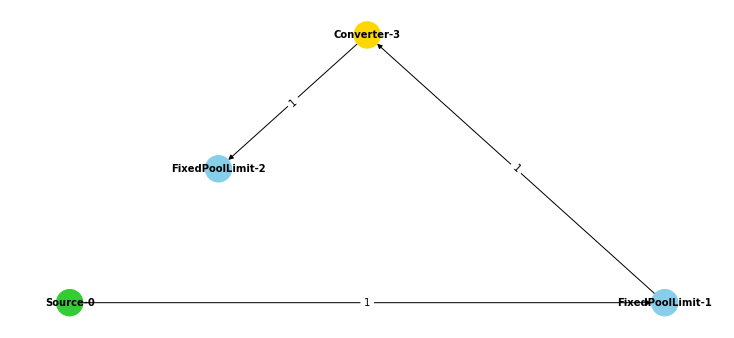

In [3]:
s_in = StateConnectionPoolRegister(variable_name="a", output_pool_id=2, register_input_id=0)
s_out = StateConnectionRegisterEdge(output_register_id=0, edge_input_id=(0,1), modifier=10)
r = Register(condition="a > 2")
r.add_input(s_in)
r.add_output(s_out)

g3 = Graph3(config=conf, edge_list=[(0, 1), (1, 3), (3, 2)], weights=[1, 1, 1], registers=[r])
g3.plot()

In [7]:
r.output_state_connection[0]

In [8]:
g3.registers

In [12]:
g3.simulate(20)

Eval cond: 1 > 2 False
Eval cond: 2 > 2 False
Eval cond: 3 > 2 True
Eval cond: 4 > 2 True
Eval cond: 5 > 2 True
Eval cond: 6 > 2 True
Eval cond: 7 > 2 True
Eval cond: 8 > 2 True
Eval cond: 9 > 2 True
Eval cond: 10 > 2 True
Eval cond: 11 > 2 True
Eval cond: 12 > 2 True
Eval cond: 13 > 2 True
Eval cond: 14 > 2 True
Eval cond: 15 > 2 True
Eval cond: 16 > 2 True
Eval cond: 17 > 2 True
Eval cond: 18 > 2 True
Eval cond: 19 > 2 True
Eval cond: 20 > 2 True


{<geevo.nodes.FixedPoolLimit at 0x253a3015f90>: [0,
  0,
  0,
  9,
  18,
  27,
  36,
  45,
  54,
  63,
  72,
  81,
  90,
  99,
  99,
  99,
  99,
  99,
  99,
  99],
 <geevo.nodes.FixedPoolLimit at 0x253a3014d00>: [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20]}

# The NMMO Economy

In [122]:
from geevo.nodes import *
from geevo.graph import Graph2, Graph3
from tqdm.notebook import tqdm
from geevo.simulation import Simulator

%load_ext autoreload
%autoreload 2

%matplotlib inline

def init_nmmo_graph():
    
    conf = {
        Source: 2,          # 0, 1
        FixedPoolLimit: 4,  # 2, 3, 4, 5
        Converter: 3,       # 6, 7, 8
        RandomGate: 2,      # 9, 10
        Drain: 4,           # 11, 12, 13, 14
        Pool: 2             # 15, 16
    }
    # pool-2: health
    # pool-3: water
    # pool-4: count buffer food
    # pool-5: food counter --> not implemented
    # pool-6: food
    
    
    edge_list = [(0, 9), (0, 10), (1, 2), # sources
                 (2, 11),    (3, 12), (4, 8), (4, 14), (5, 13), # pools1
                 (9, 7), (9, 15), (10, 6), (10, 16), # random gates
                 (6, 3), (7, 4) ,(8, 5) # converters
                 ] 
    
    s_in_food = StateConnectionPoolRegister(variable_name="food", output_pool_id=5, register_input_id=0)
    s_in_water = StateConnectionPoolRegister(variable_name="water", output_pool_id=3, register_input_id=0)
    s_out_health_regain = StateConnectionRegisterEdge(output_register_id=0, edge_input_id=(1, 2), modifier=10)
    regain_health_register = Register(condition="water > 0 and food > 0", name="Regain Health Register")
    regain_health_register.add_input(s_in_food)
    regain_health_register.add_input(s_in_water)
    regain_health_register.add_output(s_out_health_regain)
    
    
    s_in_food = StateConnectionPoolRegister(variable_name="food", output_pool_id=5, register_input_id=0)
    s_in_water = StateConnectionPoolRegister(variable_name="water", output_pool_id=3, register_input_id=0)
    s_out_health_drop = StateConnectionRegisterEdge(output_register_id=0, edge_input_id=(2, 11), modifier=10)
    lose_health_register = Register(condition="water == 0 or food == 0", name="Lose Health Register")
    lose_health_register.add_input(s_in_food)
    lose_health_register.add_input(s_in_water)
    lose_health_register.add_output(s_out_health_drop)
    
    # end condition
    
    
    weights = [1,1,0, # sources
               0,10,1,1,10, # pools  
               0.06, 0.94, 0.74,0.26, # random gates
               100, 2, 100] # converters
    
    g3 = Graph3(config=conf, edge_list=edge_list, weights=weights, registers=[regain_health_register, lose_health_register])
    # Sources
    g3.nodes[0].name = "Step"
    g3.nodes[1].name = "Health"
    
    # Pools
    g3.nodes[2].name = "Health"
    g3.nodes[2].pool = 100
    g3.nodes[3].name = "Water"
    g3.nodes[3].pool = 100
    g3.nodes[4].name = "Food Count Buffer"
    g3.nodes[5].name = "Food"
    g3.nodes[5].pool = 100
    g3.nodes[14].name = "Food Counter"
    
    # g3.plot(figsize=(15, 7.5))
    return g3


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
win_looses = []
game_lengths = []
for i in tqdm(range(100)):
    g3 = init_nmmo_graph()
    win_cond = EndCondition(g3.nodes[14], 14, "Food Counter >= 5", WinStates.PLAYER_WINS)
    loose_cond = EndCondition(g3.nodes[2], 2, "Health <= 0", WinStates.PLAYER_LOST)
    
    res, win_loose, game_length = g3.simulate(25, win_conditions=[win_cond, loose_cond])
    win_looses.append(win_loose)
    game_lengths.append(game_length)
    # for node, data in res.items():
    #     if isinstance(node, FixedPoolLimit):
    #         print(node.name, data)
    #     if node.name == "Food Counter":
    #         print(node.name, data)
np.mean(game_lengths)

  0%|          | 0/100 [00:00<?, ?it/s]

23.29

In [15]:
134656 * 60 / 512

15780.0

In [8]:
game_lengths

[25,
 25,
 25,
 25,
 23,
 20,
 25,
 25,
 25,
 20,
 20,
 25,
 20,
 25,
 20,
 25,
 20,
 25,
 25,
 21,
 25,
 25,
 25,
 20,
 25,
 20,
 25,
 20,
 25,
 25,
 25,
 20,
 25,
 21,
 25,
 25,
 25,
 25,
 20,
 20,
 20,
 25,
 25,
 20,
 25,
 25,
 25,
 25,
 25,
 24,
 20,
 18,
 25,
 25,
 20,
 25,
 25,
 25,
 25,
 20,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 24,
 20,
 20,
 20,
 25,
 25,
 20,
 25,
 20,
 25,
 20,
 25,
 25,
 20,
 20,
 18,
 25,
 25,
 23,
 25,
 20,
 25,
 25,
 22,
 25,
 25,
 25,
 25,
 20,
 25,
 20]

In [4]:
np.mean(game_lengths)

23.0

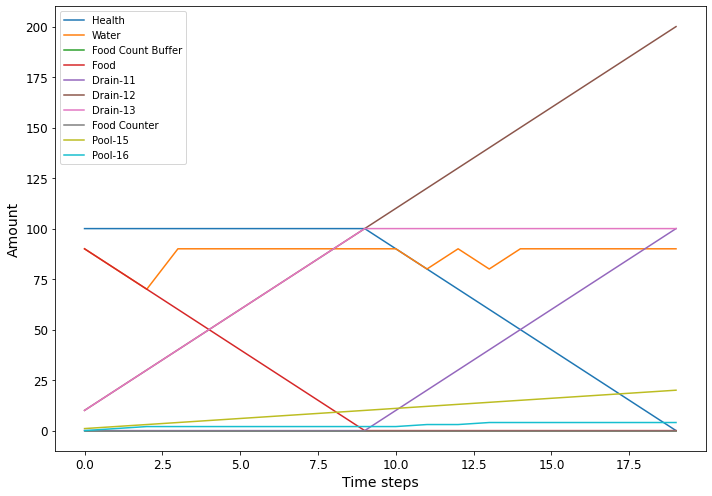

In [16]:
g3.simulator.plot_monitor(drains=True)

## Plotting hard scripted NMMO graph

{0: array([-10.        ,  -2.64604811]), 9: array([ 0.51546392, -0.30927835]), 10: array([ 5.18900344, -1.47766323]), 1: array([ 7.5257732 , -2.64604811]), 2: array([ 6.35738832, -1.47766323]), 11: array([ 5.77319588, -2.06185567]), 3: array([2.26804124, 0.27491409]), 12: array([ 1.09965636, -0.89347079]), 4: array([-2.40549828,  1.44329897]), 8: array([-4.1580756 ,  2.02749141]), 14: array([-3.57388316,  2.61168385]), 5: array([-4.74226804,  2.61168385]), 13: array([-7.0790378 ,  0.27491409]), 6: array([ 2.85223368, -0.30927835]), 7: array([-1.82130584,  0.85910653]), 15: array([-1.2371134 ,  1.44329897]), 16: array([3.43642612, 0.27491409])}


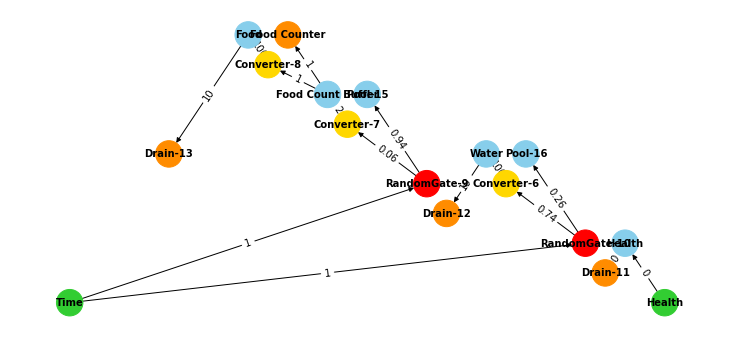

In [35]:
g3.plot()

In [123]:
g3 = init_nmmo_graph()

In [68]:
g3.edge_list.append((3, 17))
g3.nodes.append(Register(condition="water > 0 and food > 0", name="Regain Health Register"))

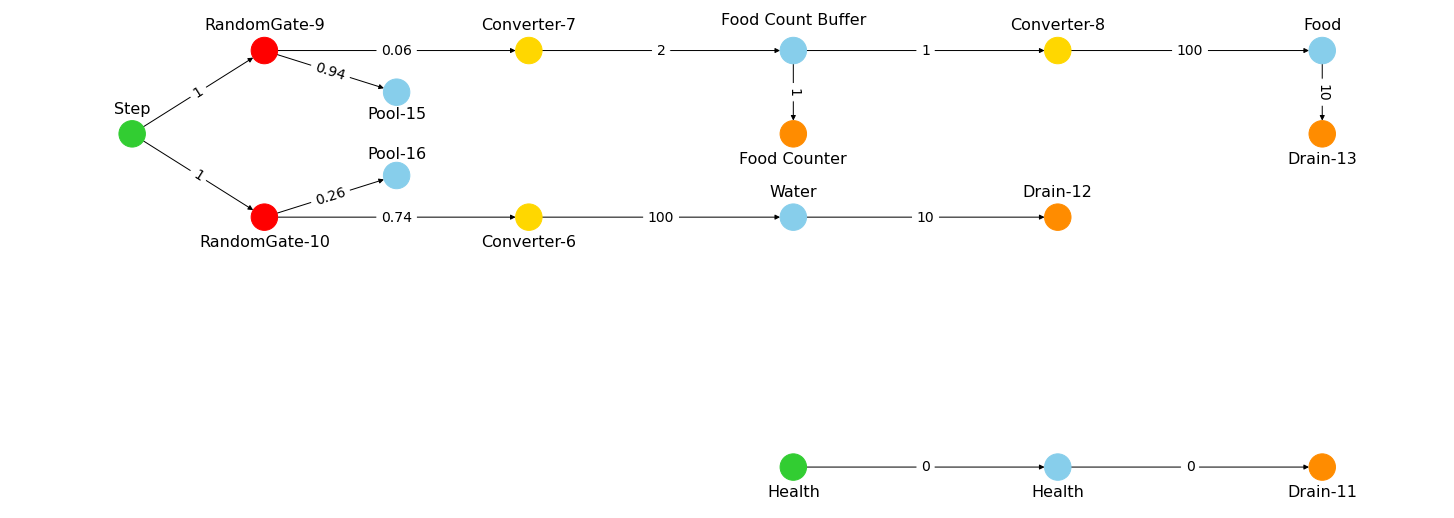

In [125]:
pos = {0:  [5.,  5], 1: [17.5, -5], # Sources
   2: [22.5, -5], 3: [17.5, 2.5], 4: [17.5, 7.5], 5: [27.5, 7.5], # Fixed Pools
   6: [12.5, 2.5], 7: [12.5, 7.5], 8: [22.5, 7.5], # Converters
   9: [7.5 ,  7.5],  10: [7.5,  2.5], # Random Gates
   11: [27.5, -5], 12: [22.5, 2.5], 13: [27.5, 5], 14: [17.5, 5], #Drains
   15: [10, 6.25], 16: [10, 3.75], 17: [1,1]} # Pools

label_pos = {0: [pos[0][0], pos[0][1] + 0.75], 1: [pos[1][0], pos[1][1] - 0.75], # Sources
   2: [pos[2][0], pos[2][1] - 0.75], 3: [pos[3][0], pos[3][1] + 0.75], 4: [pos[4][0], pos[4][1] + 0.9], 5: [pos[5][0], pos[5][1] + 0.75], # Fixed Pools
   6: [pos[6][0], pos[6][1] - 0.75], 7: [pos[7][0], pos[7][1] + 0.75], 8: [pos[8][0], pos[8][1] + 0.75], # Converters
   9: [pos[9][0], pos[9][1] + 0.75],  10: [pos[10][0], pos[10][1] - 0.75], # Random Gates
   11: [pos[11][0], pos[11][1] - 0.75], 12: [pos[12][0], pos[12][1] + 0.75], 13: [pos[13][0], pos[13][1] - 0.75], 14: [pos[14][0], pos[14][1] - 0.75], #Drains
   15: [pos[15][0], pos[15][1] - 0.65], 16: [pos[16][0], pos[16][1] + 0.65]} # Pools

g3.plot(pos=pos, figsize=(20, 7), save=True, filename="nmmo_graph.png", label_pos=label_pos)